### 数据处理

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [2]:
try:
    df = pd.read_csv("数据\Project_Data_Cleaned.csv")
    print(df.head())
except FileNotFoundError:
    print("文件 'Project_Data_Cleaned.csv' 未找到。")

   CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0       50001      1       4                Phone         3                6   
1       50002      1       9                Phone         1                8   
2       50003      1       9                Phone         1               30   
3       50004      1       3                Phone         3               15   
4       50005      1       3                Phone         1               12   

  MaritalStatus  AgeGroup  Gender  HourSpendOnApp  OrderCount  \
0        Single         3  Female               3           1   
1        Single         4    Male               3           1   
2        Single         4    Male               2           1   
3        Single         4    Male               2           1   
4        Single         3    Male               3           1   

   OrderAmountHikeFromlastYear  DaySinceLastOrder    PreferedOrderCat  \
0                           11                  5  Lapt

<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
C:\Users\myw\AppData\Local\Temp\ipykernel_30548\760478792.py:2: SyntaxWarning: invalid escape sequence '\P'
  df = pd.read_csv("数据\Project_Data_Cleaned.csv")


In [3]:
print("\n--- 数据信息 (df.info()) ---")
df.info()

print("\n--- 检查缺失值 (df.isnull().sum()) ---")
print(df.isnull().sum())

if 'Churn' in df.columns:
    print("\n--- 目标变量 'Churn' 的分布 ---")
    print(df['Churn'].value_counts(normalize=True))
    print("数据探索完毕。")
else:
    print("\n错误: 目标变量 'Churn' 未在数据中找到。")


--- 数据信息 (df.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   CustomerID                   5630 non-null   int64 
 1   Churn                        5630 non-null   int64 
 2   Tenure                       5630 non-null   int64 
 3   PreferredLoginDevice         5630 non-null   object
 4   CityTier                     5630 non-null   int64 
 5   WarehouseToHome              5630 non-null   int64 
 6   MaritalStatus                5630 non-null   object
 7   AgeGroup                     5630 non-null   int64 
 8   Gender                       5630 non-null   object
 9   HourSpendOnApp               5630 non-null   int64 
 10  OrderCount                   5630 non-null   int64 
 11  OrderAmountHikeFromlastYear  5630 non-null   int64 
 12  DaySinceLastOrder            5630 non-null   int64 
 13  Prefere

In [4]:
# 特征工程与预处理

# CustomerID 是一个标识符，不参与建模
if 'CustomerID' in df.columns:
    df_processed = df.drop('CustomerID', axis=1)
else:
    df_processed = df.copy()

# 定义特征 (X) 和目标 (y)
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

# 自动识别数值特征和类别特征
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# 一些int类型的列其实是类别，需要手动移过去
potential_cats = ['CityTier', 'AgeGroup', 'SatisfactionScore', 'Complain']
for col in potential_cats:
    if col in numeric_features:
        # 确保列存在于X中
        if col in X.columns:
            numeric_features.remove(col)
            categorical_features.append(col)

print(f"\n数值特征 (Numeric Features): {numeric_features}")
print(f"类别特征 (Categorical Features): {categorical_features}")

# 创建预处理 Pipeline
# 数值特征：标准化
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 类别特征：独热编码（忽略未见过的类别）
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 使用 ColumnTransformer 组合数值和类别的 Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("\n预处理器 (preprocessor) 创建成功。")


数值特征 (Numeric Features): ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'OrderCount', 'OrderAmountHikeFromlastYear', 'DaySinceLastOrder', 'NumberOfStreamerFollowed', 'CouponUsed', 'DiscountAmount']
类别特征 (Categorical Features): ['PreferredLoginDevice', 'MaritalStatus', 'Gender', 'PreferedOrderCat', 'CityTier', 'AgeGroup', 'SatisfactionScore', 'Complain']

预处理器 (preprocessor) 创建成功。


In [5]:
# 数据拆分 (使用 stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("数据拆分完成。")
print(f"训练集 X_train: {X_train.shape}")
print(f"测试集 X_test: {X_test.shape}")

数据拆分完成。
训练集 X_train: (4504, 17)
测试集 X_test: (1126, 17)


### 模型训练

In [6]:
# 定义模型
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(probability=True, random_state=42), # probability=True 才能计算 ROC-AUC
    'Random Forest': RandomForestClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

print("模型定义完成。")
print(f"即将比较的模型: {list(models.keys())}")

模型定义完成。
即将比较的模型: ['Logistic Regression', 'Naive Bayes', 'KNN', 'SVC', 'Random Forest', 'LightGBM']


In [7]:
# 循环训练、评估和存储结果
results = []
fitted_models = {}

print("\n--- 开始模型训练与评估 ---")

for name, model in models.items():
    # 创建完整的 Pipeline（预处理 + 分类器）
    clf_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    print(f"\n开始训练: {name}")
    
    # 训练
    clf_pipeline.fit(X_train, y_train)
    
    # 预测
    y_pred = clf_pipeline.predict(X_test)
    
    # 预测概率（用于 ROC-AUC）
    # 检查模型是否有 predict_proba
    if hasattr(clf_pipeline.named_steps['classifier'], 'predict_proba'):
        y_pred_proba = clf_pipeline.predict_proba(X_test)[:, 1]
    else:
        # 备用方案（例如 SVC 默认没有 probability）
        y_pred_proba = clf_pipeline.decision_function(X_test)
        y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())

    # 计算指标
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"\n--- {name} 评估结果 ---")
    print(f"准确率 (Accuracy): {accuracy:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("分类报告 (Classification Report):")
    # target_names=['Not Churn (0)', 'Churn (1)']
    print(classification_report(y_test, y_pred, target_names=['Not Churn (0)', 'Churn (1)']))
    
    # 存储结果
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'ROC-AUC': roc_auc
    })
    
    # 存储拟合的
    fitted_models[name] = clf_pipeline
    print(f"--- {name} 训练评估完成 ---")

print("\n---所有模型训练评估完成 ---")


--- 开始模型训练与评估 ---

开始训练: Logistic Regression

--- Logistic Regression 评估结果 ---
准确率 (Accuracy): 0.8819
ROC-AUC: 0.8772
分类报告 (Classification Report):
               precision    recall  f1-score   support

Not Churn (0)       0.91      0.96      0.93       936
    Churn (1)       0.71      0.51      0.59       190

     accuracy                           0.88      1126
    macro avg       0.81      0.73      0.76      1126
 weighted avg       0.87      0.88      0.87      1126

--- Logistic Regression 训练评估完成 ---

开始训练: Naive Bayes

--- Naive Bayes 评估结果 ---
准确率 (Accuracy): 0.7087
ROC-AUC: 0.7623
分类报告 (Classification Report):
               precision    recall  f1-score   support

Not Churn (0)       0.93      0.70      0.80       936
    Churn (1)       0.33      0.74      0.46       190

     accuracy                           0.71      1126
    macro avg       0.63      0.72      0.63      1126
 weighted avg       0.83      0.71      0.74      1126

--- Naive Bayes 训练评估完成 ---

开始训练: KN

### 模型结果对比

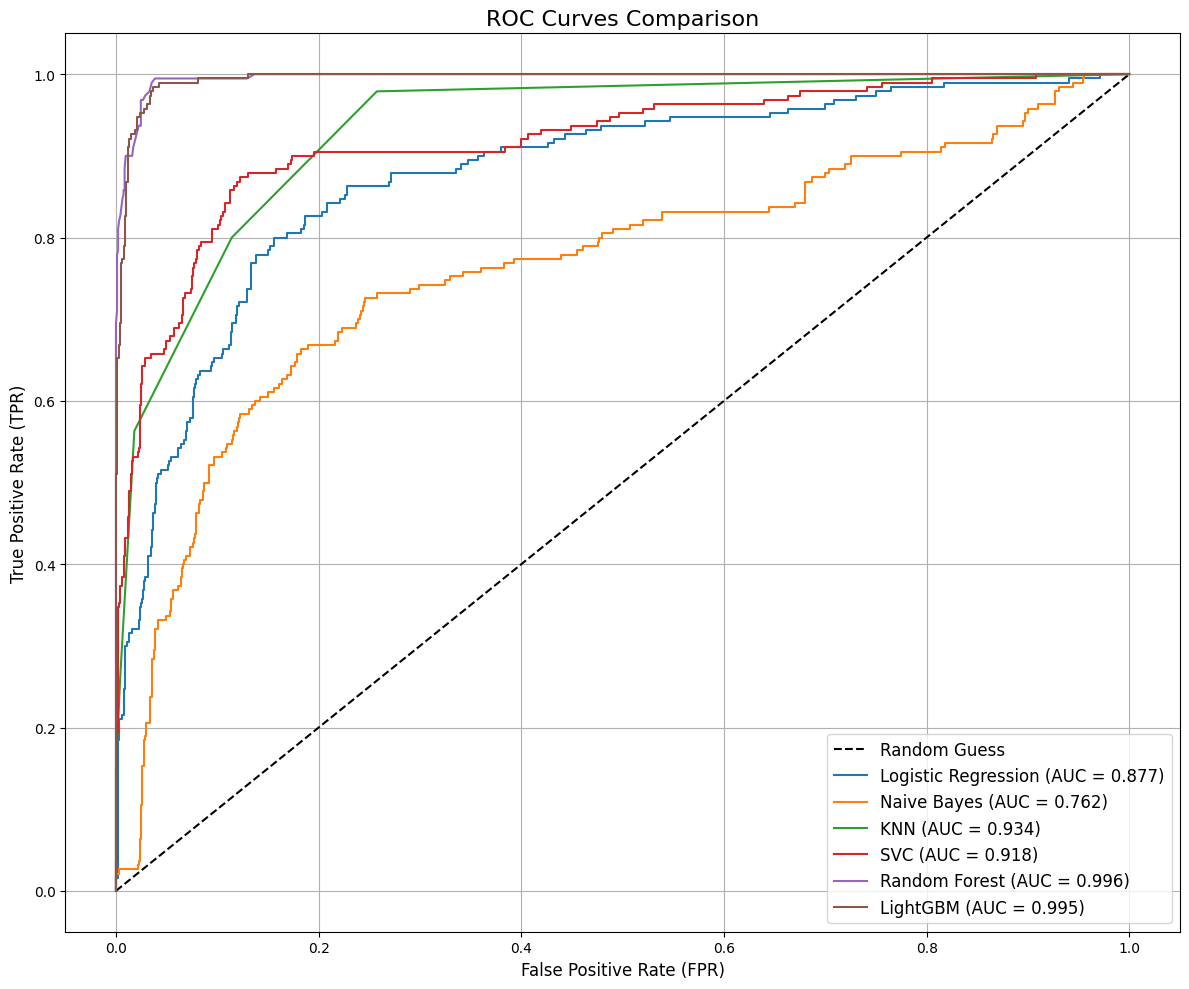

In [8]:
# 模型对比（ROC曲线）
plt.figure(figsize=(12, 10))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess') # 随机猜测线

for name, pipeline in fitted_models.items():
    # 重新获取概率
    if hasattr(pipeline.named_steps['classifier'], 'predict_proba'):
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = pipeline.decision_function(X_test)
        y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())
        
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
# plt.savefig('roc_curves_comparison.png')

# print("ROC 曲线对比图已保存为 'roc_curves_comparison.png'")
plt.show()

In [9]:
# 结果汇总
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='ROC-AUC', ascending=False).reset_index(drop=True)

print("\n--- 所有模型性能对比 ---")
print(results_df)

# results_df.to_csv("model_comparison_results.csv", index=False)
# print("\n模型对比结果已保存到 'model_comparison_results.csv'")


--- 所有模型性能对比 ---
                 Model  Accuracy   ROC-AUC
0        Random Forest  0.967140  0.996216
1             LightGBM  0.968917  0.994799
2                  KNN  0.911190  0.934196
3                  SVC  0.906750  0.917915
4  Logistic Regression  0.881883  0.877159
5          Naive Bayes  0.708703  0.762298


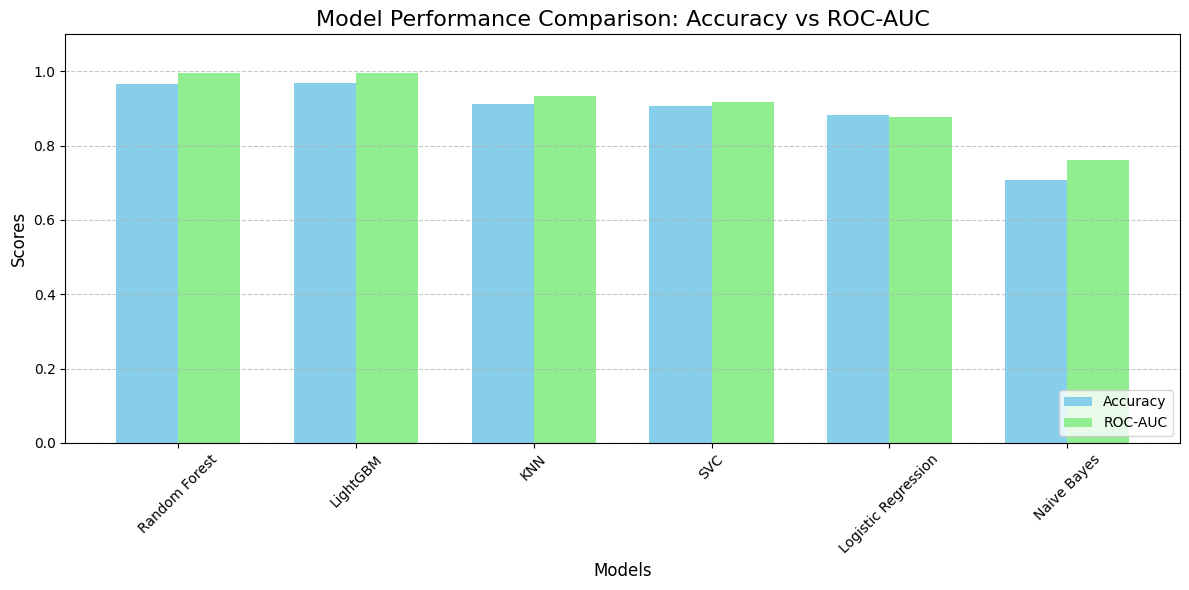

In [10]:
# 可视化模型性能对比 (Accuracy vs ROC-AUC)
# 创建一个条形图来对比所有模型的指标
plt.figure(figsize=(12, 6))

x = np.arange(len(results_df['Model']))
width = 0.35  # 条形的宽度

# 绘制 Accuracy 条形
plt.bar(x - width/2, results_df['Accuracy'], width, label='Accuracy', color='skyblue')
# 绘制 ROC-AUC 条形
plt.bar(x + width/2, results_df['ROC-AUC'], width, label='ROC-AUC', color='lightgreen')

plt.xlabel('Models', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title('Model Performance Comparison: Accuracy vs ROC-AUC', fontsize=16)
plt.xticks(x, results_df['Model'], rotation=45) # 旋转X轴标签以免重叠
plt.legend(loc='lower right') # 图例位置
plt.ylim(0, 1.1) # 设置Y轴范围略大于1，留出空间
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# plt.savefig('结果图/model_performance_bar_chart.png')
# print("\n模型性能对比条形图已保存为 'model_performance_bar_chart.png'")
plt.show()

### 特征重要性分析（随机森林）


--- 特征重要性分析 (Random Forest) ---

Random Forest 模型中前 10 个最重要的特征：
                        Feature  Importance
0                        Tenure    0.166335
8                DiscountAmount    0.096252
1               WarehouseToHome    0.076694
6      NumberOfStreamerFollowed    0.064892
5             DaySinceLastOrder    0.061471
4   OrderAmountHikeFromlastYear    0.059708
37                   Complain_1    0.035476
36                   Complain_0    0.034921
3                    OrderCount    0.032346
7                    CouponUsed    0.028979


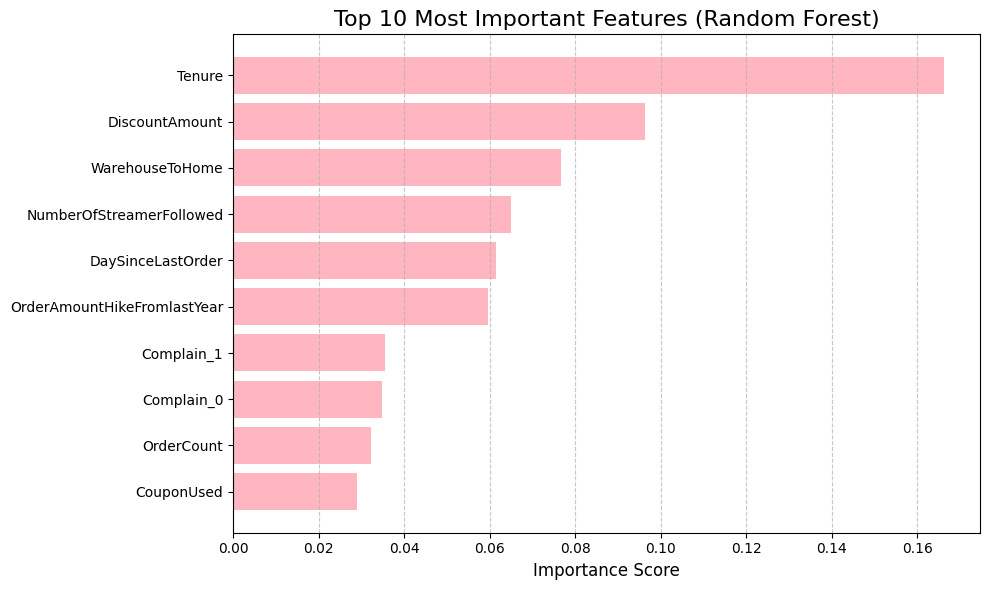

In [11]:
# 特征重要性分析 (针对 Random Forest)
print("\n--- 特征重要性分析 (Random Forest) ---")

# 从 fitted_models 中获取训练好的 Random Forest Pipeline
rf_pipeline = fitted_models['Random Forest']
rf_model = rf_pipeline.named_steps['classifier']
preprocessor_step = rf_pipeline.named_steps['preprocessor']

# 获取特征名称
# 数值特征名称 (直接使用 numeric_features)
num_names = numeric_features

# 类别特征名称 (从 OneHotEncoder 中获取处理后的特征名)
# 注意：OneHotEncoder 会将一个类别列拆分为多个列 (例如 Gender -> Gender_Male, Gender_Female)
cat_names = preprocessor_step.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)

# 合并所有特征名称
all_feature_names = np.r_[num_names, cat_names]

# 获取特征重要性数值
importances = rf_model.feature_importances_

# 创建一个 DataFrame 来存储和排序特征重要性
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 输出前5个最重要的特征
print("\nRandom Forest 模型中前 10 个最重要的特征：")
print(feature_importance_df.head(10))

# 可视化特征重要性 (Top 10)
top_n = 10
top_features = feature_importance_df.head(top_n)

plt.figure(figsize=(10, 6))
# 为了让最重要的显示在最上面，我们需要反转数据
plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1], color='lightpink')

plt.xlabel('Importance Score', fontsize=12)
plt.title(f'Top {top_n} Most Important Features (Random Forest)', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# plt.savefig('结果图/rf_feature_importance.png')
# print(f"\n特征重要性图表已保存为 'rf_feature_importance.png'")
plt.show()

# # 保存完整特征重要性列表
# feature_importance_df.to_csv('feature_importance.csv', index=False)
# print("完整特征重要性列表已保存到 'feature_importance.csv'")

### 特征重要性分析（LightGBM）


--- LightGBM 特征重要性分析 ---
Top 5 Most Important Features (LightGBM):
                        Feature  Importance
8                DiscountAmount         425
1               WarehouseToHome         361
0                        Tenure         309
4   OrderAmountHikeFromlastYear         248
6      NumberOfStreamerFollowed         242
5             DaySinceLastOrder         217
3                    OrderCount         115
36                   Complain_0         106
13         MaritalStatus_Single          80
35          SatisfactionScore_5          68


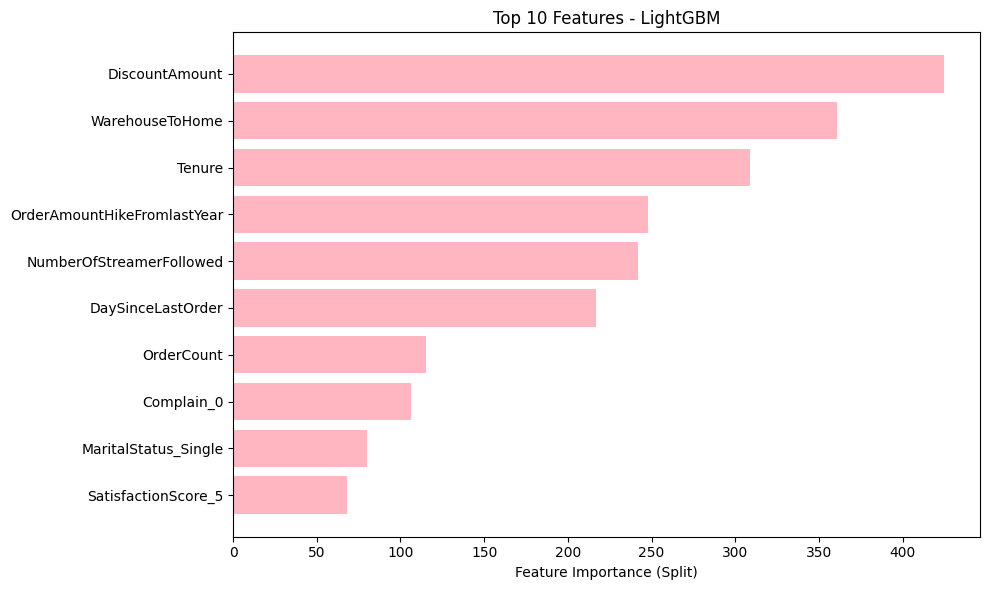

In [12]:
# --- 提取并输出特征重要性 ---
print("\n--- LightGBM 特征重要性分析 ---")

# 获取模型对象

lgbm_pipeline = fitted_models['LightGBM']
lgbm_model = lgbm_pipeline.named_steps['classifier']
preprocessor_step = lgbm_pipeline.named_steps['preprocessor']

# 获取特征名称
# 数值特征名
num_names = numeric_features
# 类别特征名 (从 OneHotEncoder 获取)
cat_names = lgbm_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = np.r_[num_names, cat_names]

# 获取重要性数值 (默认是 'split')
importances = lgbm_model.feature_importances_

# 创建 DataFrame
lgbm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 输出前 5 名
print("Top 5 Most Important Features (LightGBM):")
print(lgbm_importance_df.head(10))

# --- 5. 可视化 ---
plt.figure(figsize=(10, 6))
top_features = lgbm_importance_df.head(10)
plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1], color='lightpink')
plt.xlabel('Feature Importance (Split)')
plt.title('Top 10 Features - LightGBM')
plt.tight_layout()
plt.show()